In [10]:
import matplotlib.pyplot as plt
import numpy as np
from retrain_ablooper import *
import torch

**3.1 Model trained on 16-04, 1 decoy, optimiser: RAdam, 268 epochs, batch size = 1**

Plot losses

In [11]:
def get_loss(loss_text, **kwargs):
    if kwargs['loss'] == 'train':
        which = 0
    elif kwargs['loss'] == 'val':
        which = 1
    
    losses = []
    loss_text = loss_text[1:] # remove header
    for i in range(len(loss_text)):
        losses.append(float(loss_text[i].strip().split('|')[which]))
    
    return np.asarray(losses)

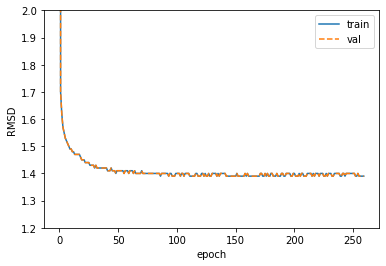

In [12]:
with open('losses_1604.out', 'r') as f:
    text = f.readlines()
loss_text = text[4:]

train_loss = get_loss(loss_text, loss='train')
val_loss = get_loss(loss_text, loss='val')

plt.plot(train_loss, label='train')
plt.plot(val_loss, '--', label='val')
plt.ylim((1.2,2))
plt.legend()
plt.ylabel('RMSD')
plt.xlabel('epoch')
plt.savefig('figures/train_val_losses-1604.png')

Get rmsd for each CDR on val set with best weights

In [13]:
# initialise model
model = MaskDecoyGen(decoys=1).to(device = device).float()
model.load_state_dict(torch.load("best_model1604", map_location=torch.device(device)))

<All keys matched successfully>

In [14]:
def cdr_rmsd_val_set(decoys, val_dataloader):
    '''
    Calculates the mean rmsd per cdr for a validation set
    '''
    CDRs = ['H1', 'H2', 'H3', 'L1', 'L2', 'L3']
    cdr_rmsds = torch.zeros(decoys, 100, len(CDRs))
    
    with torch.no_grad():
        model.eval() 

        for i, data in enumerate(val_dataloader):
            node_features = data['encodings']
            coordinates = data['geomins']
            out_coordinates = data['geomouts']
            mask = data['mask']

            pred = model(node_features, coordinates, mask)

            cdr_rmsds[:,i,:] = rmsd_per_cdr(pred, node_features, out_coordinates, CDRs, decoys)

        return cdr_rmsds.mean(1)

In [15]:
# Does not run in this notebook but results shon below
# (see retrain_model.ipynb for working code)
# cdr_rmsd = cdr_rmsd_val_set(1, val_dataloader)
# print('H1, H2, H3, L1, L2, L3')
# cdr_rmsd

H1, H2, H3, L1, L2, L3
tensor([[1.2416, 1.2083, 3.2649, 1.2498, 0.6153, 1.3835]])

**3.2 Model trained on 18-04, 1 decoy, optimiser: Adam, batch size = 1**

In [16]:
with open('training_loss-1804-Adam-1.json', 'r') as f:
    losses = json.load(f)

cdr rmsd after 200 epochs [[1.22105074 1.35108876 3.2126615  1.33345342 0.74024475 1.46290863]]


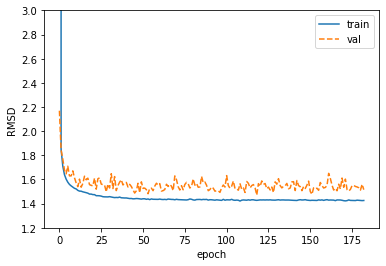

In [17]:
train_loss = losses['train_losses']
val_loss = losses['val_lossers']
cdr_rmsd = losses['cdr_rmsd']

plt.plot(train_loss, label='train')
plt.plot(val_loss, '--', label='val')
plt.ylim((1.2,3))
plt.legend()
plt.ylabel('RMSD')
plt.xlabel('epoch')
plt.savefig('figures/train_val_losses-1804-Adam-1.png')

cdr_rmsd = np.array(cdr_rmsd)
min_i = np.where(cdr_rmsd[:,2] == np.amin(cdr_rmsd[:,2]))
print('cdr rmsd after 200 epochs', cdr_rmsd[min_i])